In [44]:
from __future__ import print_function
import pickle
from matplotlib import pyplot
import numpy as np
import os
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from IPython.core.debugger import set_trace
from sklearn.metrics import roc_curve, auc, roc_auc_score
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

In [9]:
dataset_type = 'process'
#dataset_type = 'domain'

OUTPUT_DIR = 'output'

if dataset_type == 'domain':
    OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'domain_results.pkl')
    INPUT_FILE = os.path.join('data', 'domains_spoof.pkl')
    IMAGE_FILE = os.path.join(OUTPUT_DIR, 'domains_roc_curve.png')
    OUTPUT_NAME = 'Domain Spoofing'
elif dataset_type == 'process':
    OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'process_results.pkl')
    INPUT_FILE = os.path.join('data', 'process_spoof.pkl')
    IMAGE_FILE = os.path.join(OUTPUT_DIR, 'process_roc_curve.png')
    OUTPUT_NAME = 'Process Spoofing'
else:
    raise Exception('Unknown dataset type: %s' % (dataset_type,))

In [10]:
def generate_imgs(strings, font_location, font_size, image_size, text_location):
    font = ImageFont.truetype(font_location, font_size)

    str_imgs = []

    for st in strings:
        # Create a single channel image of floats
        img1 = Image.new('F', image_size)
        dimg = ImageDraw.Draw(img1)
        dimg.text(text_location, st.lower(), font=font)
        
        img1 = np.expand_dims(img1, axis=0)

        str_imgs.append(img1)

    return np.array(str_imgs, dtype=np.float32)

In [28]:
font_location = "Arial.ttf"
font_size = 10
image_size = (150, 12)
text_location = (0, 0)

with open(INPUT_FILE, 'rb') as f:
    data = pickle.load(f)
        
data['train'] = random.sample(data['train'], 80)
data['validate'] = random.sample(data['validate'], 10)
data['test'] = random.sample(data['test'], 10)

In [379]:
X1_train = generate_imgs([x[0] for x in data['train']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) ) 
X2_train = generate_imgs([x[1] for x in data['train']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
y_train = [x[2] for x in data['train']]

X1_valid = generate_imgs([x[0] for x in data['validate']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
X2_valid = generate_imgs([x[1] for x in data['validate']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
y_valid = [x[2] for x in data['validate']]

X1_test = generate_imgs([x[0] for x in data['test']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
X2_test = generate_imgs([x[1] for x in data['test']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
y_test = [x[2] for x in data['test']]

0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0


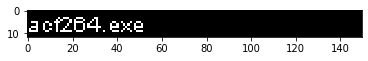

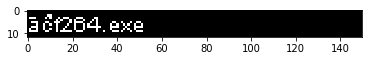

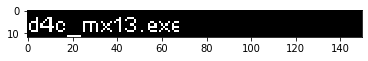

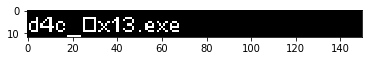

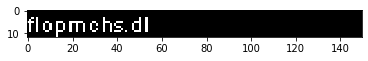

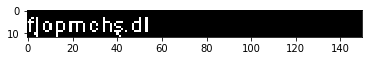

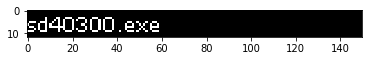

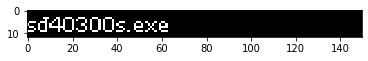

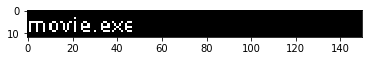

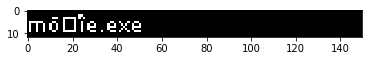

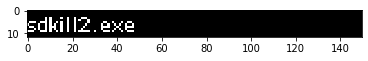

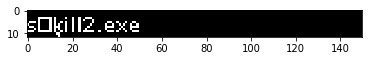

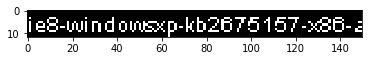

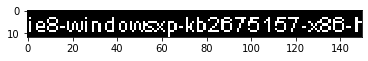

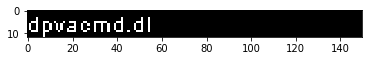

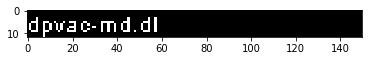

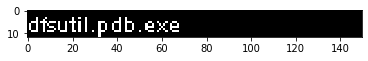

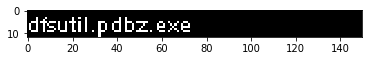

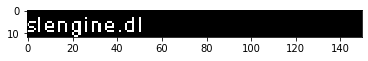

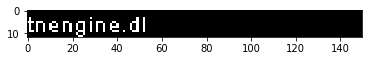

In [348]:
for ii in range(10):
    iii = X1_train[ii].reshape((12, 150))
    pyplot.figure()
    pyplot.imshow(iii, cmap="gray")
    
    iii = X2_train[ii].reshape((12, 150))
    pyplot.figure()
    pyplot.imshow(iii, cmap="gray")
    
    print(y_test[ii])

In [380]:
def permute_shapes(collection):
    return collection.permute(0, 3, 1, 2)

def tensorify(collection):
    return torch.from_numpy(collection)

def arrange_dataset(X1, X2, y, batch_size=8, shuffle=True):
    X1_new = X1.unsqueeze(1)
    X2_new = X2.unsqueeze(1)
    y_new = torch.FloatTensor(y)
    
    dataset_large = torch.cat((X1_new, X2_new), 1)
    print(dataset_large.shape)
    print(y_new.shape)

    from torch.utils.data import DataLoader
    from torch.utils.data import TensorDataset
    large_dataset = TensorDataset(dataset_large, y_new)
    large_data_loader = DataLoader(large_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return large_data_loader

X1_train = permute_shapes(tensorify(X1_train))
X2_train = permute_shapes(tensorify(X2_train))
X1_valid = permute_shapes(tensorify(X1_valid))
X2_valid = permute_shapes(tensorify(X2_valid))
X1_test = permute_shapes(tensorify(X2_test))
X2_test = permute_shapes(tensorify(X2_test))

train_loader = arrange_dataset(X1_train, X2_train, y_train)
valid_loader = arrange_dataset(X1_valid, X2_valid, y_valid)
test_loader = arrange_dataset(X1_test, X2_test, y_test)

torch.Size([80, 2, 1, 12, 150])
torch.Size([80])
torch.Size([10, 2, 1, 12, 150])
torch.Size([10])
torch.Size([10, 2, 1, 12, 150])
torch.Size([10])


In [246]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin=margin

    def forward(self, output1, output2, label):
        output1 = output1.type(torch.DoubleTensor)
        output2 = output2.type(torch.DoubleTensor)
        label = label.type(torch.DoubleTensor)

        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                        label   * torch.pow(torch.clamp(self.margin-euclidean_distance, min=0.0), 2))

        return loss_contrastive

class Siamese_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
        self.fc = nn.Linear(64 * 35, 32)

    def forward_once(self, x):
        x = F.leaky_relu(self.conv1(x), 0.1)
        x = F.max_pool2d(x, 2, 2)
        x = F.leaky_relu(self.conv2(x), 0.1)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 35)
        return self.fc(x)
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [376]:
siamese = Siamese_CNN()

In [392]:
optimizer_siamese = optim.Adam(siamese.parameters(), lr=0.01)
from keras import backend as K

def train(model, device, train_loader, optimizer, epoch, batch_size=8):
    log_interval = int(8 / batch_size)
    criterion = ContrastiveLoss()
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # initialize as zeros all the gradients of the model
        optimizer.zero_grad()
        data_permuted = data.permute(1, 0, 2, 3, 4)
        data1 = data_permuted[0]
        data2 = data_permuted[1]
        
        output1, output2 = model(data1, data2)
        
        # compute average loss for the current batch
        loss = criterion(output1, output2, target)
        # backpropagate the gradients
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
for epoch in range(1, 20 + 1):    
    train(siamese, None, train_loader, optimizer_siamese, epoch)

Train Epoch: 1 [0/80 (0%)]	Loss: 0.010171
Train Epoch: 1 [8/80 (10%)]	Loss: 0.033496
Train Epoch: 1 [16/80 (20%)]	Loss: 0.031239
Train Epoch: 1 [24/80 (30%)]	Loss: 0.043132
Train Epoch: 1 [32/80 (40%)]	Loss: 0.082203
Train Epoch: 1 [40/80 (50%)]	Loss: 0.166933
Train Epoch: 1 [48/80 (60%)]	Loss: 0.040757
Train Epoch: 1 [56/80 (70%)]	Loss: 0.067728
Train Epoch: 1 [64/80 (80%)]	Loss: 0.453498
Train Epoch: 1 [72/80 (90%)]	Loss: 0.411487
Train Epoch: 2 [0/80 (0%)]	Loss: 0.521111
Train Epoch: 2 [8/80 (10%)]	Loss: 0.288431
Train Epoch: 2 [16/80 (20%)]	Loss: 0.068241
Train Epoch: 2 [24/80 (30%)]	Loss: 0.742083
Train Epoch: 2 [32/80 (40%)]	Loss: 0.701959
Train Epoch: 2 [40/80 (50%)]	Loss: 0.022766
Train Epoch: 2 [48/80 (60%)]	Loss: 0.325390
Train Epoch: 2 [56/80 (70%)]	Loss: 0.360895
Train Epoch: 2 [64/80 (80%)]	Loss: 0.285925
Train Epoch: 2 [72/80 (90%)]	Loss: 0.195511
Train Epoch: 3 [0/80 (0%)]	Loss: 0.104507
Train Epoch: 3 [8/80 (10%)]	Loss: 0.297803
Train Epoch: 3 [16/80 (20%)]	Loss: 0.3011

Train Epoch: 19 [64/80 (80%)]	Loss: 0.003987
Train Epoch: 19 [72/80 (90%)]	Loss: 0.001679
Train Epoch: 20 [0/80 (0%)]	Loss: 0.000638
Train Epoch: 20 [8/80 (10%)]	Loss: 0.001702
Train Epoch: 20 [16/80 (20%)]	Loss: 0.000164
Train Epoch: 20 [24/80 (30%)]	Loss: 0.005761
Train Epoch: 20 [32/80 (40%)]	Loss: 0.000656
Train Epoch: 20 [40/80 (50%)]	Loss: 0.002328
Train Epoch: 20 [48/80 (60%)]	Loss: 0.001465
Train Epoch: 20 [56/80 (70%)]	Loss: 0.007654
Train Epoch: 20 [64/80 (80%)]	Loss: 0.000702
Train Epoch: 20 [72/80 (90%)]	Loss: 0.004816


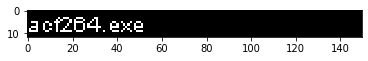

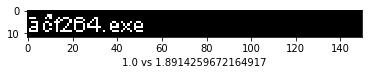

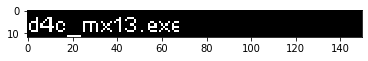

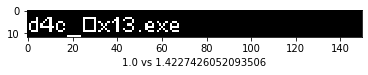

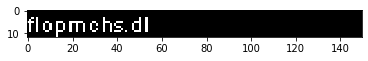

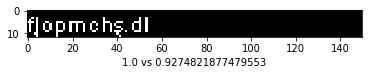

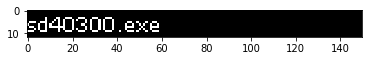

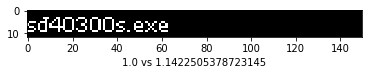

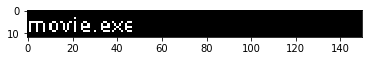

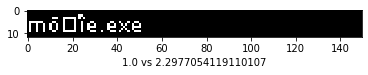

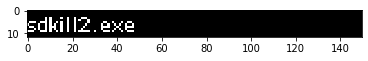

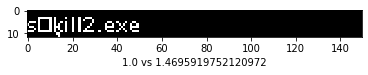

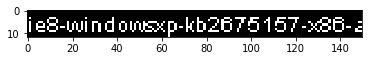

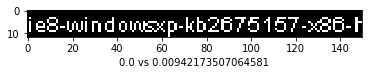

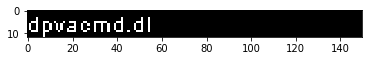

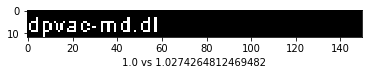

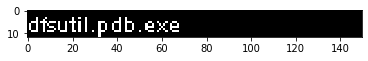

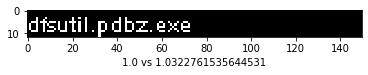

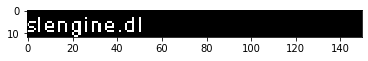

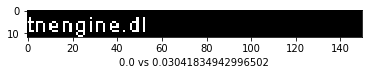

In [444]:
def checker(loader):
    for i in range(10):
        input1 = loader.dataset.tensors[0][i][0]
        input2 = loader.dataset.tensors[0][i][1]
        label = loader.dataset.tensors[1][i]
        o1, o2 = siamese(input1.unsqueeze(0), input2.unsqueeze(0))

        iii = input1.reshape((12, 150))
        pyplot.figure()
        pyplot.imshow(iii, cmap="gray")

        iii = input2.reshape((12, 150))
        pyplot.figure()
        pyplot.xlabel(str(label.item()) + " vs " + str(F.pairwise_distance(o1, o2).item()))
        pyplot.imshow(iii, cmap="gray")
        
checker(train_loader)